In [ ]:
!pip install cleverhans

In [3]:
import os
from sklearn.model_selection import train_test_split
import sklearn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the dataset folder
data_dir = '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir,transform=transform)

# Extract labels from the dataset
labels = np.array([label for _, label in full_dataset.samples])

# Define the stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Get indices for train and test sets
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

# Create subsets for training and testing
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=4)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Baseline model

In [ ]:
import torchvision.models as models
resnet50_baseline = models.resnet50(pretrained=True)
for param in resnet50_baseline.parameters():
    param.requires_grad = False
resnet50_baseline.fc = torch.nn.Linear(resnet50_baseline.fc.in_features, 90)# num_classes is the number of your dataset classes
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_baseline.fc.parameters(), lr=0.0005)  # Only optimize the final layer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_baseline = resnet50_baseline.to(device)
resnet50_baseline = nn.DataParallel(resnet50_baseline)

# Set the model to training mode
resnet50_baseline.train()
num_epochs=5
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50_baseline (inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

for param in resnet50_baseline.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(resnet50_baseline.parameters(), lr=0.0001)
num_epochs=10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50_baseline(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
#For evaluation :
resnet50_baseline.eval()
#Save model
torch.save(resnet50_baseline.state_dict(),'resnet50_state_dict.pth')
print("Done")

Adversarial training with FGM attack

In [ ]:
import torchvision.models as models
resnet50_fgm = models.resnet50(pretrained=True)
for param in resnet50_fgm.parameters():
    param.requires_grad = False
resnet50_fgm.fc = torch.nn.Linear(resnet50_fgm.fc.in_features, 90)# num_classes is the number of your dataset classes
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_fgm.fc.parameters(), lr=0.0005)  # Only optimize the final layer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_fgm = resnet50_fgm.to(device)
resnet50_fgm = nn.DataParallel(resnet50_fgm)

# Set the model to training mode
resnet50_fgm.train()
num_epochs=5
epsilon = 0.1
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial images
        adversarial_images = fast_gradient_method(model_fn=resnet50_fgm, x=inputs, eps=epsilon, norm=np.inf)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass with natural images
        outputs = resnet50_fgm(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize with natural images
        loss.backward()
        optimizer.step()

        # Zero the parameter gradients again
        optimizer.zero_grad()

        # Forward pass with adversarial images
        adv_outputs = resnet50_fgm(adversarial_images)
        adv_loss = criterion(adv_outputs, labels)

        # Backward pass and optimize with adversarial images
        adv_loss.backward()
        optimizer.step()

        running_loss += loss.item() + adv_loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/(len(train_loader)*2)}')

for param in resnet50_fgm.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(resnet50_fgm.parameters(), lr=0.0001)
num_epochs=10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        adversarial_images = fast_gradient_method(model_fn=resnet50_fgm, x=inputs, eps=epsilon, norm=np.inf)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50_fgm(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        # Forward pass with adversarial images
        adv_outputs = resnet50_fgm(adversarial_images)
        adv_loss = criterion(adv_outputs, labels)

        # Backward pass and optimize with adversarial images
        adv_loss.backward()
        optimizer.step()

        running_loss += loss.item() + adv_loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/(len(train_loader)*2)}')
#For evaluation :
resnet50_fgm.eval()
torch.save(resnet50_fgm.state_dict(), 'resnet50_fgm_state_dict.pth')
print("Done")

ADVERSARIAL TRAINING WITH PGD ATTACK (7 iterations)

In [ ]:
resnet50_pgd = models.resnet50(pretrained=True)
for param in resnet50_pgd.parameters():
    param.requires_grad = False
resnet50_pgd.fc = torch.nn.Linear(resnet50_pgd.fc.in_features, 90)# num_classes is the number of your dataset classes
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_pgd.fc.parameters(), lr=0.0005)  # Only optimize the final layer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_pgd = resnet50_pgd.to(device)
resnet50_pgd = nn.DataParallel(resnet50_pgd)

# Set the model to training mode
resnet50_pgd.train()
num_epochs=5
epsilon = 0.1
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial images
        adversarial_images = projected_gradient_descent(model_fn=resnet50_pgd, x=inputs, eps=epsilon, norm=np.inf,rand_init=True,eps_iter=0.01,nb_iter=7)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass with natural images
        outputs = resnet50_pgd(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize with natural images
        loss.backward()
        optimizer.step()

        # Zero the parameter gradients again
        optimizer.zero_grad()

        # Forward pass with adversarial images
        adv_outputs = resnet50_pgd(adversarial_images)
        adv_loss = criterion(adv_outputs, labels)

        # Backward pass and optimize with adversarial images
        adv_loss.backward()
        optimizer.step()

        running_loss += loss.item() + adv_loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/(len(train_loader)*2)}')

for param in resnet50_pgd.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(resnet50_pgd.parameters(), lr=0.0001)
num_epochs=10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        adversarial_images = projected_gradient_descent(model_fn=resnet50_pgd, x=inputs, eps=epsilon, norm=np.inf,rand_init=True,eps_iter=0.01,nb_iter=7)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50_pgd(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        # Forward pass with adversarial images
        adv_outputs = resnet50_pgd(adversarial_images)
        adv_loss = criterion(adv_outputs, labels)

        # Backward pass and optimize with adversarial images
        adv_loss.backward()
        optimizer.step()

        running_loss += loss.item() + adv_loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/(len(train_loader)*2)}')

resnet50_pgd.eval()
print("Done")

In [ ]:
#save the model
torch.save(resnet50_pgd.state_dict(), 'resnet50_pgd_state_dict.pth')

Adversarial Interpolated Training

In [ ]:
def mixup_data(x, y):
    lam = np.random.beta(1, 1)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
resnet50_IAT = models.resnet50(pretrained=True)
for param in resnet50_IAT.parameters():
    param.requires_grad = False
resnet50_IAT.fc = torch.nn.Linear(resnet50_IAT.fc.in_features, 90)# num_classes is the number of your dataset classes
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_IAT.fc.parameters(), lr=0.0005)  # Only optimize the final layer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_IAT = resnet50_IAT.to(device)
resnet50_IAT = nn.DataParallel(resnet50_IAT)

# Set the model to training mode
resnet50_IAT.train()
num_epochs=5
epsilon = 0.1
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial images
        adversarial_images = projected_gradient_descent(model_fn=resnet50_IAT, x=inputs, eps=epsilon, norm=np.inf,rand_init=True,eps_iter=0.01,nb_iter=7)
        benign_inputs, benign_targets_a, benign_targets_b, benign_lam = mixup_data(inputs, labels)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass with natural images
        outputs = resnet50_IAT(benign_inputs)
        loss = mixup_criterion(criterion, outputs, benign_targets_a, benign_targets_b, benign_lam)
        
        # Backward pass and optimize with natural images
        loss.backward()
        optimizer.step()
        
        adv_inputs, adv_targets_a, adv_targets_b, adv_lam = mixup_data(adversarial_images , labels)
        # Zero the parameter gradients again
        optimizer.zero_grad()

        # Forward pass with adversarial images
        adv_outputs = resnet50_IAT(adv_inputs)
        adv_loss = mixup_criterion(criterion, adv_outputs, adv_targets_a, adv_targets_b, adv_lam)
        
        total_loss=loss+adv_loss
        # Backward pass and optimize with adversarial images
        adv_loss.backward()
        optimizer.step()

        running_loss += loss.item() + adv_loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/(len(train_loader)*2)}')

for param in resnet50_IAT.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(resnet50_IAT.parameters(), lr=0.0001)
num_epochs=10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial images
        adversarial_images = projected_gradient_descent(model_fn=resnet50_IAT, x=inputs, eps=epsilon, norm=np.inf,rand_init=True,eps_iter=0.01,nb_iter=7)
        benign_inputs, benign_targets_a, benign_targets_b, benign_lam = mixup_data(inputs, labels)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass with natural images
        outputs = resnet50_IAT(benign_inputs)
        loss = mixup_criterion(criterion, outputs, benign_targets_a, benign_targets_b, benign_lam)
        
        # Backward pass and optimize with natural images
        loss.backward()
        optimizer.step()
        
        adv_inputs, adv_targets_a, adv_targets_b, adv_lam = mixup_data(adversarial_images , labels)
        # Zero the parameter gradients again
        optimizer.zero_grad()

        # Forward pass with adversarial images
        adv_outputs = resnet50_IAT(adv_inputs)
        adv_loss = mixup_criterion(criterion, adv_outputs, adv_targets_a, adv_targets_b, adv_lam)

        # Backward pass and optimize with adversarial images
        adv_loss.backward()
        optimizer.step()

        running_loss += loss.item() + adv_loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/(len(train_loader)*2)}')
resnet50_IAT.eval()
torch.save(resnet50_IAT.state_dict(), 'resnet50_IAT_state_dict.pth')
print("Done")

LOAD PRETRAINED MODEL IF YOU WANT TO SAVE TIME !

In [4]:
import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet50_baseline = models.resnet50(pretrained=False)  
resnet50_baseline.fc = torch.nn.Linear(resnet50_baseline.fc.in_features, 90)  # Adjust the final layer as you did before
resnet50_baseline.load_state_dict(torch.load('/kaggle/input/pretrained/resnet50_basic_training_state_dict.pth'))
resnet50_baseline = nn.DataParallel(resnet50_baseline)
resnet50_baseline= resnet50_baseline.to(device)
resnet50_baseline.eval()

resnet50_fgm= models.resnet50(pretrained=False)  
resnet50_fgm.fc = torch.nn.Linear(resnet50_fgm.fc.in_features, 90) 
resnet50_fgm.load_state_dict(torch.load('/kaggle/input/pretrained/resnet50_fgm_state_dict.pth'))
resnet50_fgm = nn.DataParallel(resnet50_fgm)
resnet50_fgm = resnet50_fgm.to(device)
resnet50_fgm.eval()


resnet50_pgd = models.resnet50(pretrained=False)  
resnet50_pgd.fc = torch.nn.Linear(resnet50_pgd.fc.in_features, 90)  # Adjust the final layer as you did before
resnet50_pgd.load_state_dict(torch.load('/kaggle/input/pretrained/resnet50_pgd_state_dict.pth'))
resnet50_pgd = nn.DataParallel(resnet50_pgd)
resnet50_pgd = resnet50_pgd.to(device)
resnet50_pgd.eval()

resnet50_IAT = models.resnet50(pretrained=False)  
resnet50_IAT.fc = torch.nn.Linear(resnet50_IAT.fc.in_features, 90)  # Adjust the final layer as you did before
resnet50_IAT.load_state_dict(torch.load('/kaggle/input/pretrained/resnet50_IAT_state_dict.pth'))
resnet50_IAT = nn.DataParallel(resnet50_IAT)
resnet50_IAT = resnet50_IAT.to(device)
resnet50_IAT.eval()

print("Done")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Done


In [ ]:
epsilon = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

models = {
    'baseline': resnet50_baseline,
    'fgm': resnet50_fgm,
    'pgd': resnet50_pgd,
    'iat': resnet50_IAT, 
}

# Initialize accuracy dictionary with two separate entries for the two PGD attacks
accuracies = {model_name: {'natural': 0, 'fgm': 0,  'pgd_7': 0, 'pgd_20': 0} for model_name in models}

total = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    for model_name, model in models.items():
        # Generate adversarial examples for each attack using the current model
        fgm = fast_gradient_method(model_fn=model, x=images, eps=epsilon, norm=np.inf)
        pgd_7_iterations = projected_gradient_descent(model_fn=model, x=images, eps=epsilon, norm=np.inf, rand_init=True, eps_iter=0.01, nb_iter=7)
        pgd_20_iterations = projected_gradient_descent(model_fn=model, x=images, eps=epsilon, norm=np.inf, rand_init=True, eps_iter=0.01, nb_iter=20)

        # Natural images
        outputs_natural = model(images)
        _, predicted_natural = torch.max(outputs_natural.data, 1)
        accuracies[model_name]['natural'] += (predicted_natural == labels).sum().item()

        # Adversarial images
        outputs_fgm = model(fgm)
        _, predicted_fgm = torch.max(outputs_fgm.data, 1)
        accuracies[model_name]['fgm'] += (predicted_fgm == labels).sum().item()

        outputs_pgd_7 = model(pgd_7_iterations)
        _, predicted_pgd_7 = torch.max(outputs_pgd_7.data, 1)
        accuracies[model_name]['pgd_7'] += (predicted_pgd_7 == labels).sum().item()

        outputs_pgd_20 = model(pgd_20_iterations)
        _, predicted_pgd_20 = torch.max(outputs_pgd_20.data, 1)
        accuracies[model_name]['pgd_20'] += (predicted_pgd_20 == labels).sum().item()

# Convert counts to percentages
for model_name in accuracies:
    for attack_type in accuracies[model_name]:
        accuracies[model_name][attack_type] = 100 * accuracies[model_name][attack_type] / total

In [ ]:

# Print accuracies
for model_name in accuracies:
    print(f'---{model_name.upper()} Model---')
    for attack_type in accuracies[model_name]:
        print(f'Accuracy on {attack_type} attack: {accuracies[model_name][attack_type]:.2f}%')

VISUALIZE THE ATTACK

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


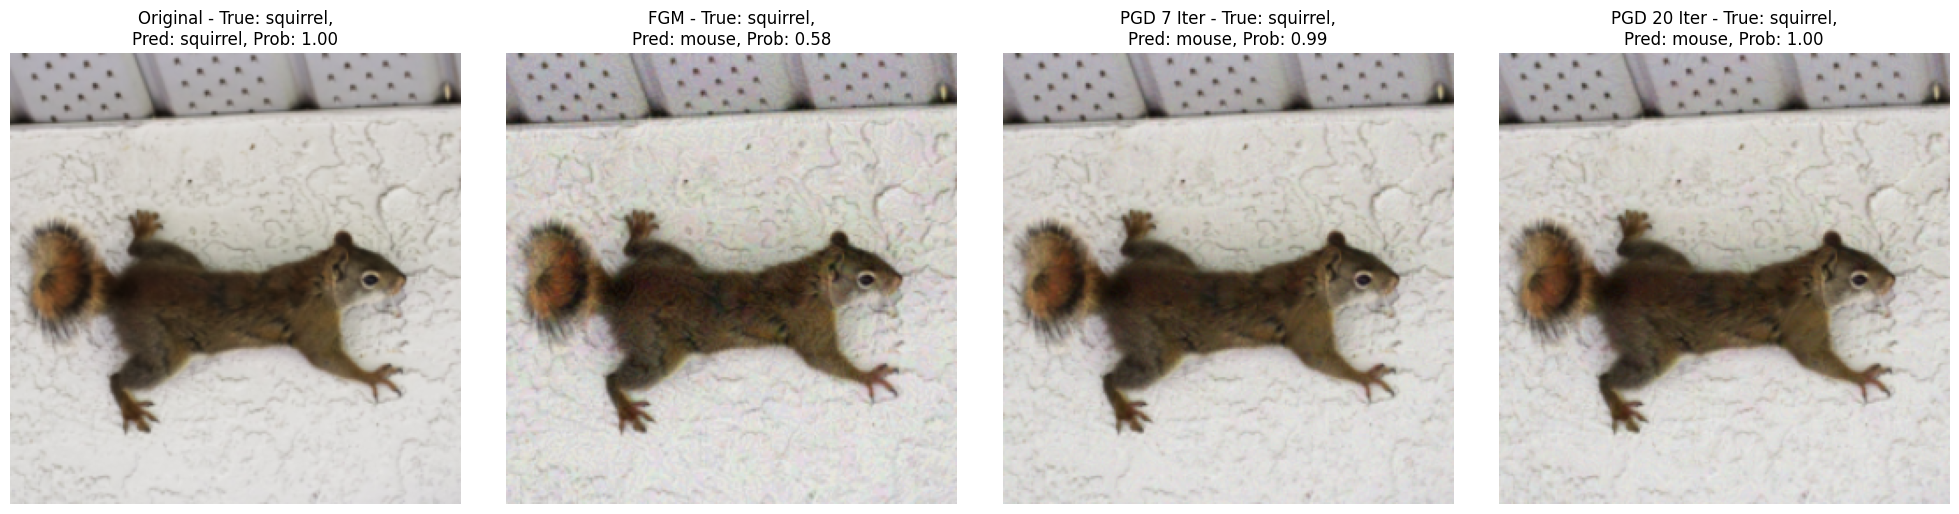

In [5]:
models = {
    'baseline': resnet50_baseline,
    'fgm': resnet50_fgm,
    'pgd': resnet50_pgd,
    'iat': resnet50_IAT, 
}
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
# Path to your dataset folder
dataset_path = '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'

# List directories in the dataset path and sort them
animal_folders = sorted(os.listdir(dataset_path))

# Create a mapping from label indices to animal names
label_to_name = {idx: name for idx, name in enumerate(animal_folders)}

def show_attack_results(model, image, label, epsilon):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Convert image to PyTorch tensor and add batch dimension
    if not torch.is_tensor(image):
        image_tensor = ToTensor()(image).unsqueeze(0).to(device)
    else:
        image_tensor = image.unsqueeze(0).to(device)
    if torch.is_tensor(label):
        label = label.item()

    # Define attacks
    fgm_attack = lambda img: fast_gradient_method(model_fn=model, x=img, eps=epsilon, norm=np.inf)
    pgd_7_attack = lambda img: projected_gradient_descent(model_fn=model, x=img, eps=epsilon, norm=np.inf, rand_init=True, eps_iter=0.01, nb_iter=7)
    pgd_20_attack = lambda img: projected_gradient_descent(model_fn=model, x=img, eps=epsilon, norm=np.inf, rand_init=True, eps_iter=0.01, nb_iter=20)

    # Dictionary to hold original and adversarial images
    images = {
        'Original': image_tensor,
        'FGM': fgm_attack(image_tensor),
        'PGD 7 Iter': pgd_7_attack(image_tensor),
        'PGD 20 Iter': pgd_20_attack(image_tensor)
    }

    # Adjust the figure size
    plt.figure(figsize=(20, 5))  # Wider plot to accommodate 4 images

    # Loop through the images and plot each one
    for i, (img_name, img_tensor) in enumerate(images.items(), start=1):
        # Model prediction for each image
        pred = model(img_tensor)
        prob = torch.nn.functional.softmax(pred, dim=1)
        predicted_label = torch.argmax(pred, dim=1)

        # Convert numeric label to animal name
        true_label_name = label_to_name[label]
        predicted_label_name = label_to_name[predicted_label.item()]

        # Resize for visualization
        resize = Resize((256, 256))
        img_tensor = resize(img_tensor[0].cpu())

        # Convert from Tensor to numpy and transpose dimensions
        img_tensor = img_tensor.detach().numpy().transpose((1, 2, 0))

        # Unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_tensor = std * img_tensor + mean
        img_tensor = np.clip(img_tensor, 0, 1)

        # Plot image
        plt.subplot(1, len(images), i)
        plt.imshow(img_tensor)
        plt.title(f'{img_name} - True: {true_label_name},\nPred: {predicted_label_name}, Prob: {prob.max().item():.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
images, labels = next(iter(train_loader))
image = images[0]
label = labels[0]
epsilon = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models['baseline']

show_attack_results(model, image, label, epsilon)